In [58]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile

In [59]:
with open("TanteKath.png", "rb") as f:
  data = f.read()
print(len(data)/8//128)

del f
del data

1547.0


In [60]:
resolution = 44_100# + 1
cycles = resolution / 4

bitrate_norm = 128
bitrate_slow = 32

high_bit_amp = 8
low_bit_amp = 1
high_bit_amp_thresh = 2.2
snr_reciprocal = 1.2
utf_bits = 8
plot_or_nah = True

In [61]:
str_msg_body = "The Nyquist theorem is also known as the sampling theorem. It is the principle to accurately reproduce a pure sine wave measurement, or sample, rate, which must be at least twice its frequency. The Nyquist theorem underpins all analog-to-digital conversion and is used in digital audio and video to reduce aliasing. The Nyquist theorem is also known as the Nyquist-Shannon theorem or the Whittaker-Nyquist-Shannon sampling theorem."
str_msg_body += "Brooklyn Gardener is so fucking cute omg <3 <3 <3 ahh i absolutely adore her eyes, pls if you existed i am all yours"

head = f"SEND{len(str_msg_body)}//"
str_msg = head + str_msg_body

def bitinize(string_or_bytes):
  str_codes = "".join([bin(ord(a))[2:].zfill(utf_bits) for a in string_or_bytes])
  return [int(a) for a in str_codes]

bin_seq = bitinize(str_msg)

len_secs = len(bin_seq)/8//bitrate_norm
if len_secs < 1:
  print("USING LOWERED BITRATE")
  len_secs = len(bin_seq)/8//bitrate_slow

print(len(bitinize(head)), "BITs head")
print(len(bitinize(str_msg_body)), "BITs body")
print(len(bin_seq), "BITs msg")
print(len_secs, "SECs")

72 BITs head
4376 BITs body
4448 BITs msg
4.0 SECs


In [62]:
len_secs = len_secs

datapoint_count = int(resolution * len_secs)

length = np.pi * 2 * cycles * len_secs
carrier_wave = np.sin(np.arange(0, length, length / datapoint_count))

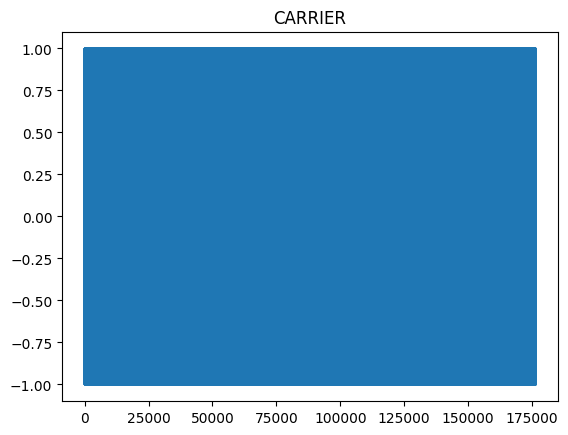

In [63]:
if plot_or_nah:
  plt.plot(carrier_wave)
  plt.title("CARRIER")
  plt.show()

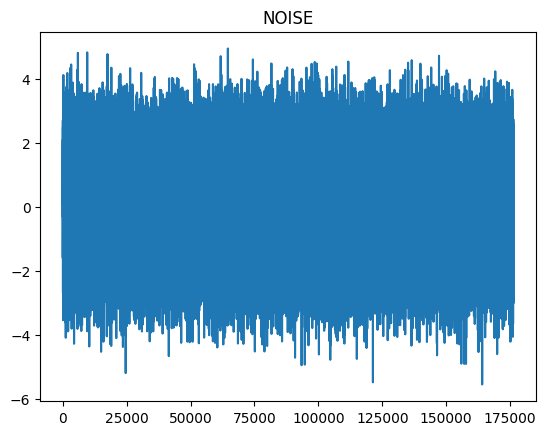

In [64]:
# Add noise
noise = np.random.randn(carrier_wave.shape[0]) * snr_reciprocal

if plot_or_nah: 
  plt.plot(noise)
  plt.title("NOISE")
  plt.show()

In [65]:
print(datapoint_count//len(bin_seq))

39


In [66]:
# I appologize for ooga booga code
holded_bin_seq = []

bit_hold_interval = int(datapoint_count//(len(bin_seq)+1))

for i in bin_seq:
    holded_bin_seq.extend([i]*bit_hold_interval)

if len(holded_bin_seq) < datapoint_count:
    holded_bin_seq.extend([0]*int(datapoint_count-len(holded_bin_seq)))

holded_bin_seq = (np.array(holded_bin_seq) * (high_bit_amp-1)) + low_bit_amp
holded_bin_seq.shape

(176400,)

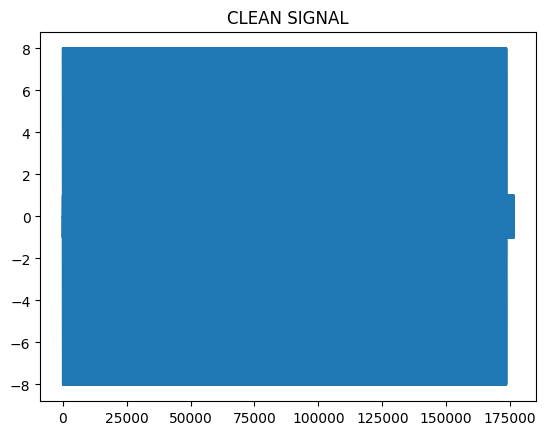

(176400,)


In [67]:
modulated = carrier_wave * holded_bin_seq
if plot_or_nah:
  plt.plot(modulated)
  plt.title("CLEAN SIGNAL") 
  plt.show()

print(carrier_wave.shape)

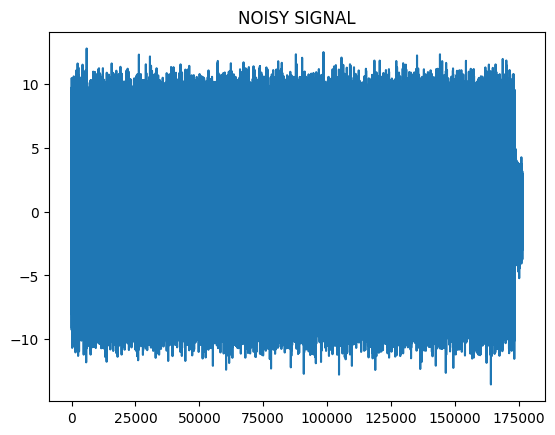

(176400,)


In [68]:
modulated_noisy = carrier_wave * holded_bin_seq + noise

if plot_or_nah:
  plt.plot(modulated_noisy)
  plt.title("NOISY SIGNAL")
  plt.show()

print(modulated_noisy.shape)
# print(np.ones(my_wave.shape))

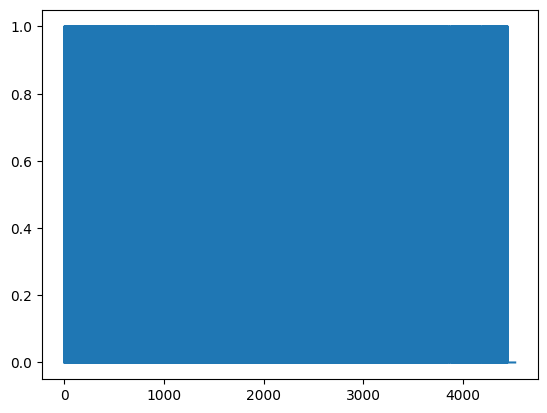

In [69]:
peak_pows_noisy = []
for d in range(bit_hold_interval,len(modulated),bit_hold_interval):
    peak_pows_noisy.append(max(np.array(modulated_noisy[d-bit_hold_interval:d]) >= (high_bit_amp-high_bit_amp_thresh)))

peak_pows_noisy = np.array(peak_pows_noisy).astype(int).tolist()
if plot_or_nah: 
    plt.plot(peak_pows_noisy)
    plt.show()

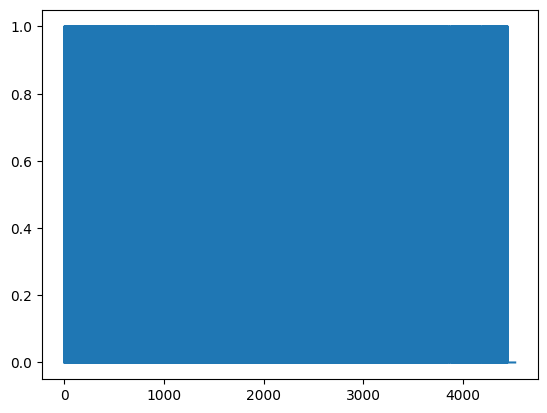

CLEAN-NOISY ERR 1 BITs FROM 4523 BITs


In [70]:
peak_pows = []
for d in range(bit_hold_interval,len(modulated),bit_hold_interval):
    peak_pows.append(max(np.array(modulated[d-bit_hold_interval:d]) >= (high_bit_amp-high_bit_amp_thresh)))

peak_pows = np.array(peak_pows).astype(int).tolist()
if plot_or_nah: 
    plt.plot(peak_pows)
    plt.show()
print("CLEAN-NOISY ERR", (len(peak_pows)-sum(np.array(peak_pows) == np.array(peak_pows_noisy))), "BITs", "FROM",len(np.array(peak_pows)), "BITs")

In [71]:
def divide_chunks(l, n):
    
    # looping till length l
    for i in range(0, len(l), n): 
        yield (l[i:i + n])

def decode_string(peak_pows_vals):
    # How many elements each
    # list should have
    n = utf_bits

    recovered_bin_seq = list(divide_chunks(peak_pows_vals, n))
    # BRACE FOR DISGUSTING DOUBLE LIST COMP
    # Actually not so bad
    recovered_bin_seq = [int("".join([str(b) for b in a]),2) for a in recovered_bin_seq]

    # TODO: This is error prone, please refactor
    recovered_char_seq = []
    for b in recovered_bin_seq:
        try:
            recovered_char_seq+=chr(b)
        except:
            recovered_char_seq+="??"
    data_str = "".join(recovered_char_seq).split("/")
    return data_str[-1], data_str[0].split("SEND")[-1]

In [72]:
print(decode_string(peak_pows)[0][:(int(decode_string(peak_pows)[1]))])
print(decode_string(peak_pows_noisy))

The Nyquist theorem is also known as the sampling theorem. It is the principle to accurately reproduce a pure sine wave measurement, or sample, rate, which must be at least twice its frequency. The Nyquist theorem underpins all analog-to-digital conversion and is used in digital audio and video to reduce aliasing. The Nyquist theorem is also known as the Nyquist-Shannon theorem or the Whittaker-Nyquist-Shannon sampling theorem.Brooklyn Gardener is so fucking cute omg <3 <3 <3 ahh i absolutely adore her eyes, pls if you existed i am all yours
('The Nyquist theorem iw also known as the sampling theorem. It is the principle to accurately reproduce a pure sine wave measurement, or sample, rate, which must be at least twice its frequency. The Nyquist theorem underpins all analog-to-digital conversion and is used in digital audio and video to reduce aliasing. The Nyquist theorem is also known as the Nyquist-Shannon theorem or the Whittaker-Nyquist-Shannon sampling theorem.Brooklyn Gardener i

In [73]:
print(chr(int(bin(ord("💗")),2)))
print(bin(ord("a")))
print("a".encode("utf-16"))

💗
0b1100001
b'\xff\xfea\x00'


In [74]:
from scipy.interpolate import interp1d
m = interp1d([min(modulated_noisy),max(modulated_noisy)],[0,255])

In [75]:
wavfile.write("modulated_clean.wav", resolution, m(modulated).astype(np.uint8))
wavfile.write("modulated_noisy.wav", resolution, m(modulated_noisy).astype(np.uint8))
wavfile.write("carrier.wav", resolution, m(carrier_wave).astype(np.uint8))
wavfile.write("noise.wav", resolution, m(noise).astype(np.uint8))

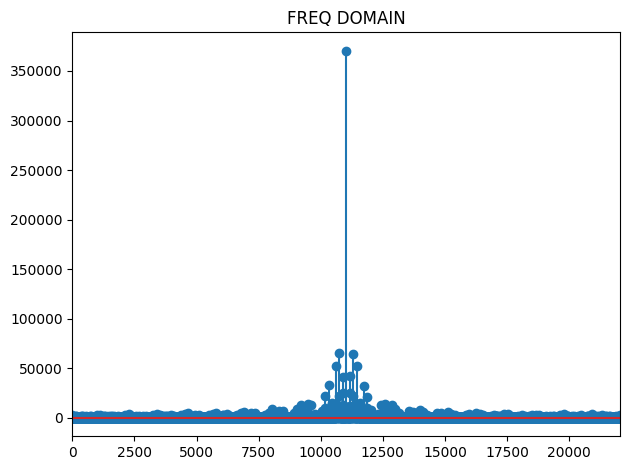

In [76]:
sp = np.fft.fft(modulated_noisy)
N = len(sp)
n = np.arange(N)
T = N/resolution
freq = n/T

# plt.subplot(1, 2, 2)
plt.title("FREQ DOMAIN")
plt.xlim(0, cycles*2)
plt.stem(freq, abs(sp))
plt.tight_layout()
plt.show()